# Импортируем нужные модули

In [79]:
import pandas as pd
import numpy as np 
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate
import plotly.express as px
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from datetime import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn import  metrics
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from optuna.samplers import TPESampler 
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostClassifier

# Импортируем данные

In [6]:
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')

# Визуализация и предобработка данных

In [7]:
train_df.drop(["id", "target_1", "target_2"], axis=1, inplace=True)    # убираем переменные таргета из треин выборки

In [5]:
# функция очистки выбросов методом Z - оценки
def delete_vibrosis(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    indexes_to_drop = set()
    newdf = df.select_dtypes(include=numerics)
    for col in newdf.columns:
        z = np.abs(stats.zscore(newdf[col]))
        vibros_indexes = newdf[z>3].index
        for i in vibros_indexes:
            indexes_to_drop.add(i)
    df.drop(index=indexes_to_drop, inplace=True)

In [6]:
# Посмотрим общее количество NA в данных

train_df.isna().sum() # кол-во NA в каждом стобце

rko_start_months                  59
max_end_fact_fin_deals        313574
max_end_plan_non_fin_deals    345094
max_start_fin_deals           315677
max_start_non_fin_deals       343958
                               ...  
cnt_days_deb_h_oper_3m          3671
sum_cred_h_oper_3m                 0
cnt_cred_h_oper_3m              3710
cnt_days_cred_h_oper_3m         3695
total_target                       0
Length: 100, dtype: int64

## Как видно NA присутсвуют в больших количествах в определенных фичах

### Логически понтяно, что nan значения в датасете не значать, что данные пропущены, это именно обозначение отсутвие срочного продукта у клиента и тд. Так как модели, обычно обрабатывают nan как пропущенные данные, для улучшения результатов мы заменили наны учень малм числом

### отдельно было решено добавить категориальную фичу по наличию срочного продукта 

In [8]:
train_df['sroch_prod']=train_df[['max_end_plan_non_fin_deals', 'max_start_non_fin_deals', 'min_end_plan_non_fin_deals']].isna().any(axis=1).astype(int)
test_df['sroch_prod']=test_df[['max_end_plan_non_fin_deals', 'max_start_non_fin_deals', 'min_end_plan_non_fin_deals']].isna().any(axis=1).astype(int)

In [9]:
# Варианты избавление от NA
train_df.fillna(-99999,inplace=True)
test_df.fillna(-99999,inplace=True)

In [10]:
test_df = test_df.apply(pd.to_numeric,errors='coerce') # переводит все значения в тип numeric, избавляемся от категориальных переменных обозначенными строкой

# Выделение категориальных перемиенных

In [11]:
cat_cols = [     # колонки с категориальным признаком
    'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment','sroch_prod'
]
train_df[cat_cols] = train_df[cat_cols].astype("category") # создаем категориальные
test_df[cat_cols] = test_df[cat_cols].astype("category") # создаем категориальные 

# Разбивка на обучающие и тестовые выборки

In [12]:
X = train_df.drop("total_target", axis=1)
y = train_df.total_target
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

# Матрица корреляций : 

<AxesSubplot:>

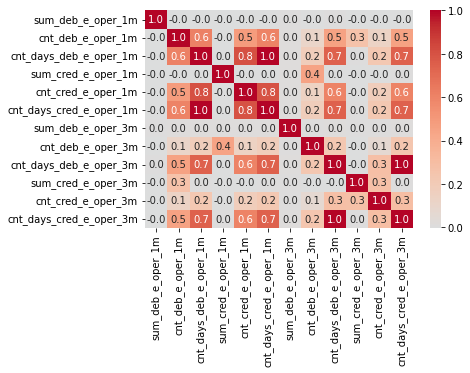

In [11]:
# Выбираем N интересующих нас параметров и создаем от них матрицу корреляций
cont = ["sum_deb_e_oper_1m","cnt_deb_e_oper_1m", "cnt_days_deb_e_oper_1m", "sum_cred_e_oper_1m", "cnt_cred_e_oper_1m", "cnt_days_cred_e_oper_1m", "sum_deb_e_oper_3m", "cnt_deb_e_oper_3m", "cnt_days_deb_e_oper_3m", "sum_cred_e_oper_3m", "cnt_cred_e_oper_3m", "cnt_days_cred_e_oper_3m"]

corr_matrix = pd.DataFrame(train_df[cont], columns = cont).corr()

sns.heatmap(corr_matrix, cmap = 'coolwarm', center = 0, annot= True, fmt = '.1f')

# Модель 1 : LightGBM

In [12]:
model1 = LGBMClassifier ()

In [13]:
param_grid = {
    'n_estimators': [ 100, 200, 300,500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [100, 200, 300, 400],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    model1, param_distributions=param_grid, n_iter=10,
    scoring='roc_auc', cv=4, n_jobs=-1, random_state=42
)

In [14]:
random_search.fit(X_train,y_train)
model1 = random_search.best_estimator_
random_search.best_params_

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 20168, number of negative: 267832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24751
[LightGBM] [Info] Number of data points in the train set: 288000, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070028 -> initscore=-2.586263
[LightGBM] [Info] Start training from score -2.586263


RandomizedSearchCV(cv=4, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'n_estimators': [100, 200, 300, 500],
                                        'num_leaves': [100, 200, 300, 400],
                                        'reg_alpha': [0.0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0.0, 0.1, 0.5, 1.0],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='roc_auc')

### Оценка модели LightGBM

In [18]:
roc_auc_score(y_val, model1.predict_proba(X_val)[:,1])

[LightGBM] [Warning] Unknown parameter: cat_features


0.8949347444303122

<Axes: title={'center': 'LightGBM Feature Importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

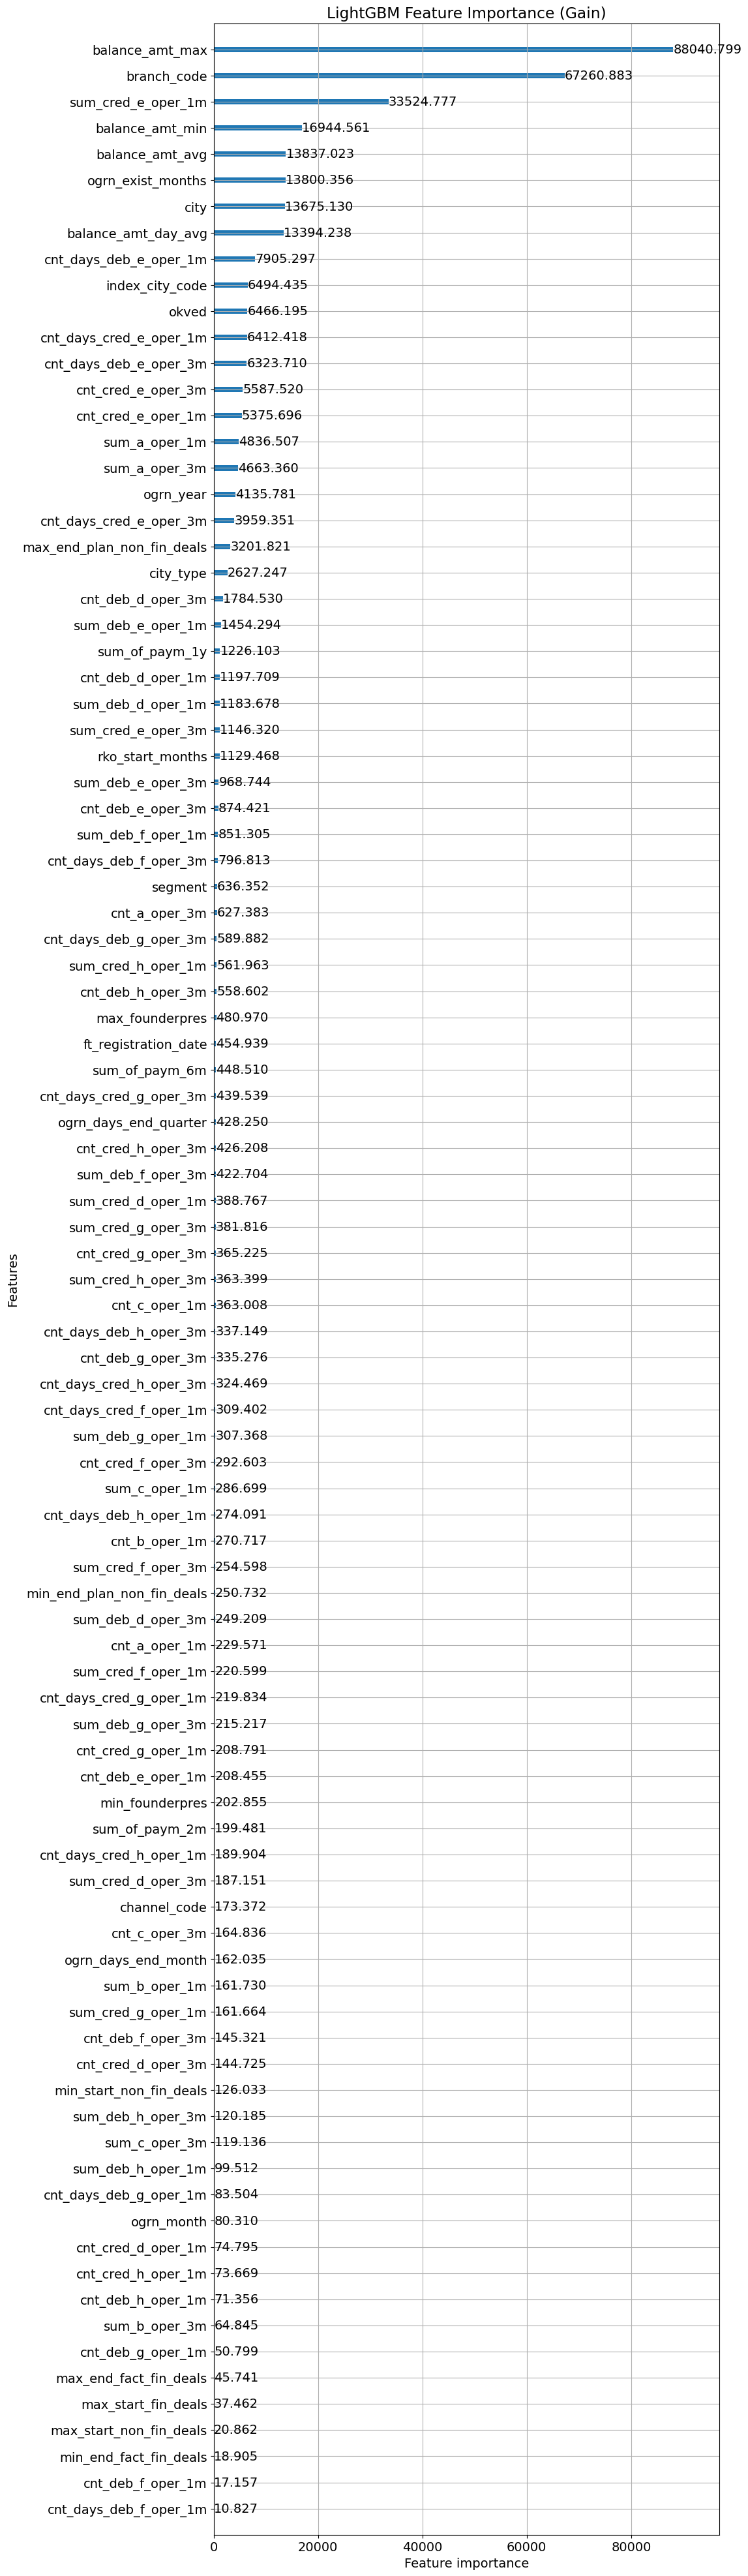

In [34]:
plot_importance(model1, importance_type="gain", figsize=(10,50), title="LightGBM Feature Importance (Gain)")

# Модель 2: XGBoost

In [37]:
model2 = XGBClassifier(enable_categorical=True, n_estimators = 600, max_depth=7, max_features='sqrt', bootstrap = True,device="cuda")

In [38]:
model2.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Оценка модели XGBoost

In [39]:
roc_auc_score(y_val, model2.predict_proba(X_val)[:,1])

0.8964873332523067

<BarContainer object of 99 artists>

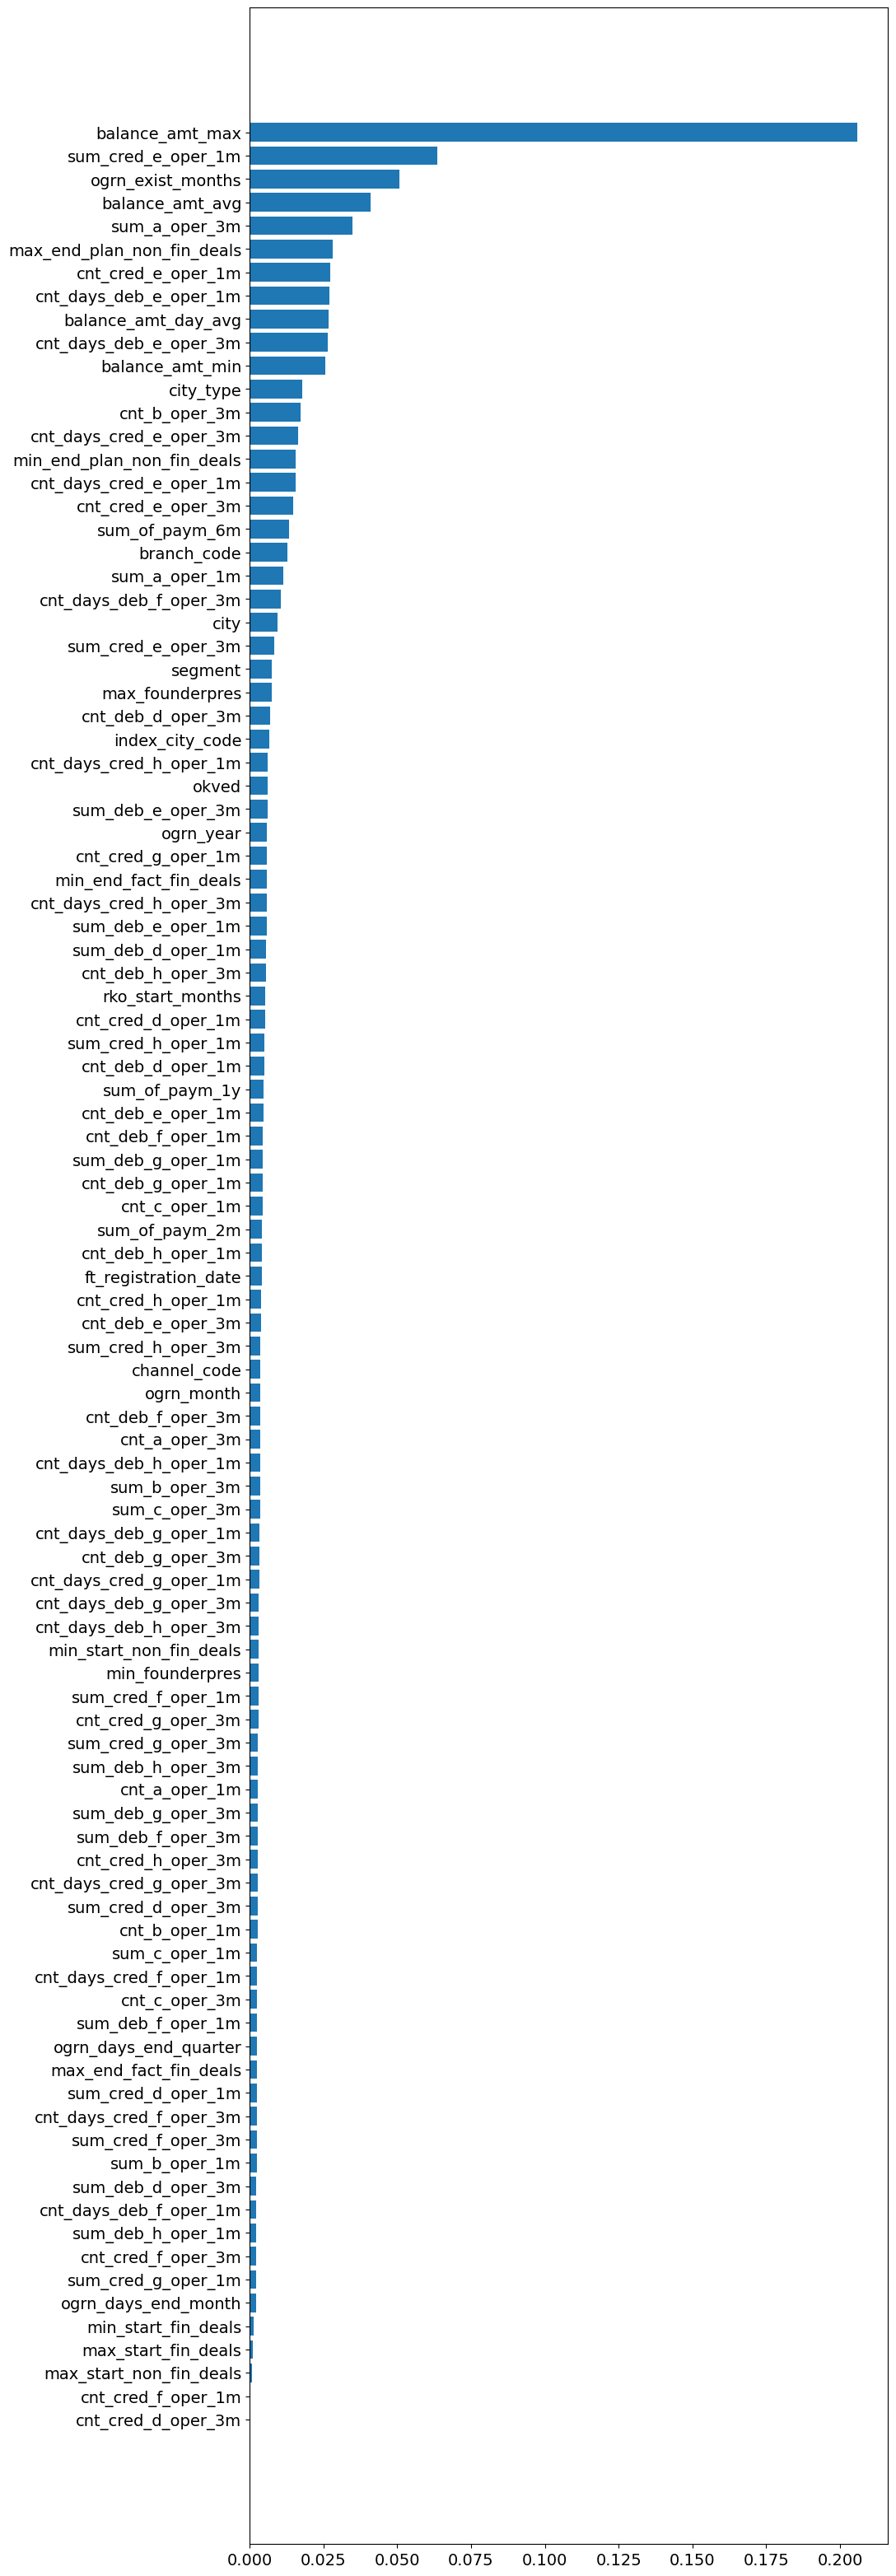

In [60]:
sorted_idx = model2.feature_importances_.argsort()

plt.figure(figsize=(10,40))

plt.barh(train_df.columns[sorted_idx], model2.feature_importances_[sorted_idx])

# Модель 3: HistGradientBoosting

In [84]:
cat_cols_for_hist = [     # колонки с категориальным признаком
    'channel_code', 'index_city_code', 'ogrn_month', 'ogrn_year',
     'okved', 'segment'
]

In [85]:
parameters = {
    'max_depth': [5,7,10],
    'max_leaf_nodes': [50,100,200,300],
    'learning_rate': [0.1, 0.01, 0.05]
}
estimator = HistGradientBoostingClassifier(categorical_features = cat_cols_for_hist)
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    cv = 5
)
grid_search.fit(X_train,y_train)
model3 = grid_search.best_estimator_

### Оценка модели HistGBM

In [87]:
roc_auc_score(y_val, model3.predict_proba(X_val)[:,1])

[LightGBM] [Warning] Unknown parameter: cat_features


0.8949347444303122

#  Модель 4: CatBoost 

In [13]:
model4 = CatBoostClassifier ( cat_features = cat_cols,
                              task_type= "GPU"
                              )

In [14]:
model4.fit(X_train,y_train)

Learning rate set to 0.024689
0:	learn: 0.6560206	total: 28ms	remaining: 28s
1:	learn: 0.6210530	total: 53.2ms	remaining: 26.6s
2:	learn: 0.5889669	total: 82.9ms	remaining: 27.5s
3:	learn: 0.5592971	total: 112ms	remaining: 27.8s
4:	learn: 0.5329157	total: 135ms	remaining: 26.8s
5:	learn: 0.5072530	total: 157ms	remaining: 26.1s
6:	learn: 0.4842537	total: 185ms	remaining: 26.2s
7:	learn: 0.4630898	total: 207ms	remaining: 25.7s
8:	learn: 0.4435166	total: 233ms	remaining: 25.7s
9:	learn: 0.4260369	total: 259ms	remaining: 25.6s
10:	learn: 0.4093634	total: 289ms	remaining: 26s
11:	learn: 0.3935220	total: 314ms	remaining: 25.8s
12:	learn: 0.3796405	total: 340ms	remaining: 25.8s
13:	learn: 0.3665630	total: 362ms	remaining: 25.5s
14:	learn: 0.3538896	total: 391ms	remaining: 25.7s
15:	learn: 0.3423140	total: 418ms	remaining: 25.7s
16:	learn: 0.3319274	total: 444ms	remaining: 25.7s
17:	learn: 0.3216454	total: 468ms	remaining: 25.5s
18:	learn: 0.3129897	total: 493ms	remaining: 25.5s
19:	learn: 0.3

### Оценка модели CatBoost

In [93]:
roc_auc_score(y_val, model4.predict_proba(X_val)[:,1])

0.9197314799094176

## Видим, хороший результат. Чаще всего catboost и справляется с классификацией лучше остальных. Будем дальше развивать его 

## Подбор гиперпараметров для методов CatBoost :

In [ ]:
catboost = CatBoostClassifier(task_type="GPU",cat_features=cat_cols,loss_function='CrossEntropy')

param_grid = {
    'iterations': [500,600,1000, 1500, 2000,2500],
    'learning_rate': [0.001,0.05, 0.1],
    'depth': [4, 6, 8, 10]
}
random_search = RandomizedSearchCV(
    catboost, param_distributions=param_grid, n_iter=10,
    scoring='roc_auc', cv=4, random_state=42
)
random_search.fit(X_train,y_train)
model1 = random_search.best_estimator_

# Интерпретация и SHAP значения

In [15]:
import shap 

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [18]:
explainer = shap.Explainer(model4) # поменять на model1
shap_values = explainer(X_train)

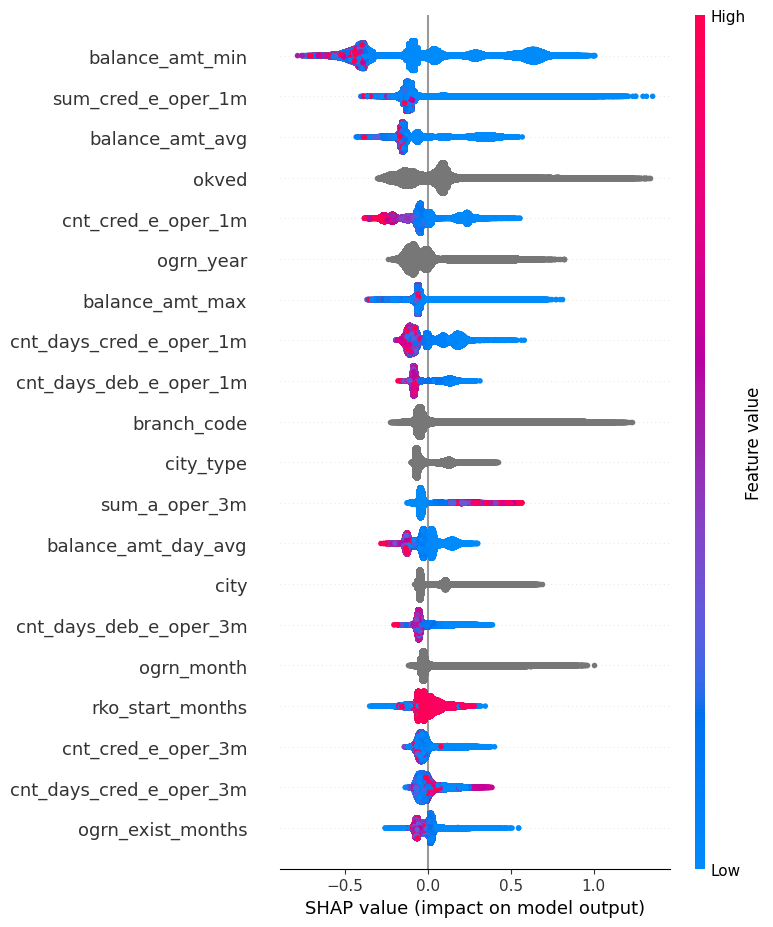

In [19]:
shap.summary_plot(shap_values, X_train )

In [20]:
shap.plots.initjs()

In [ ]:
shap.plots.bar(shap_values, max_display=99)

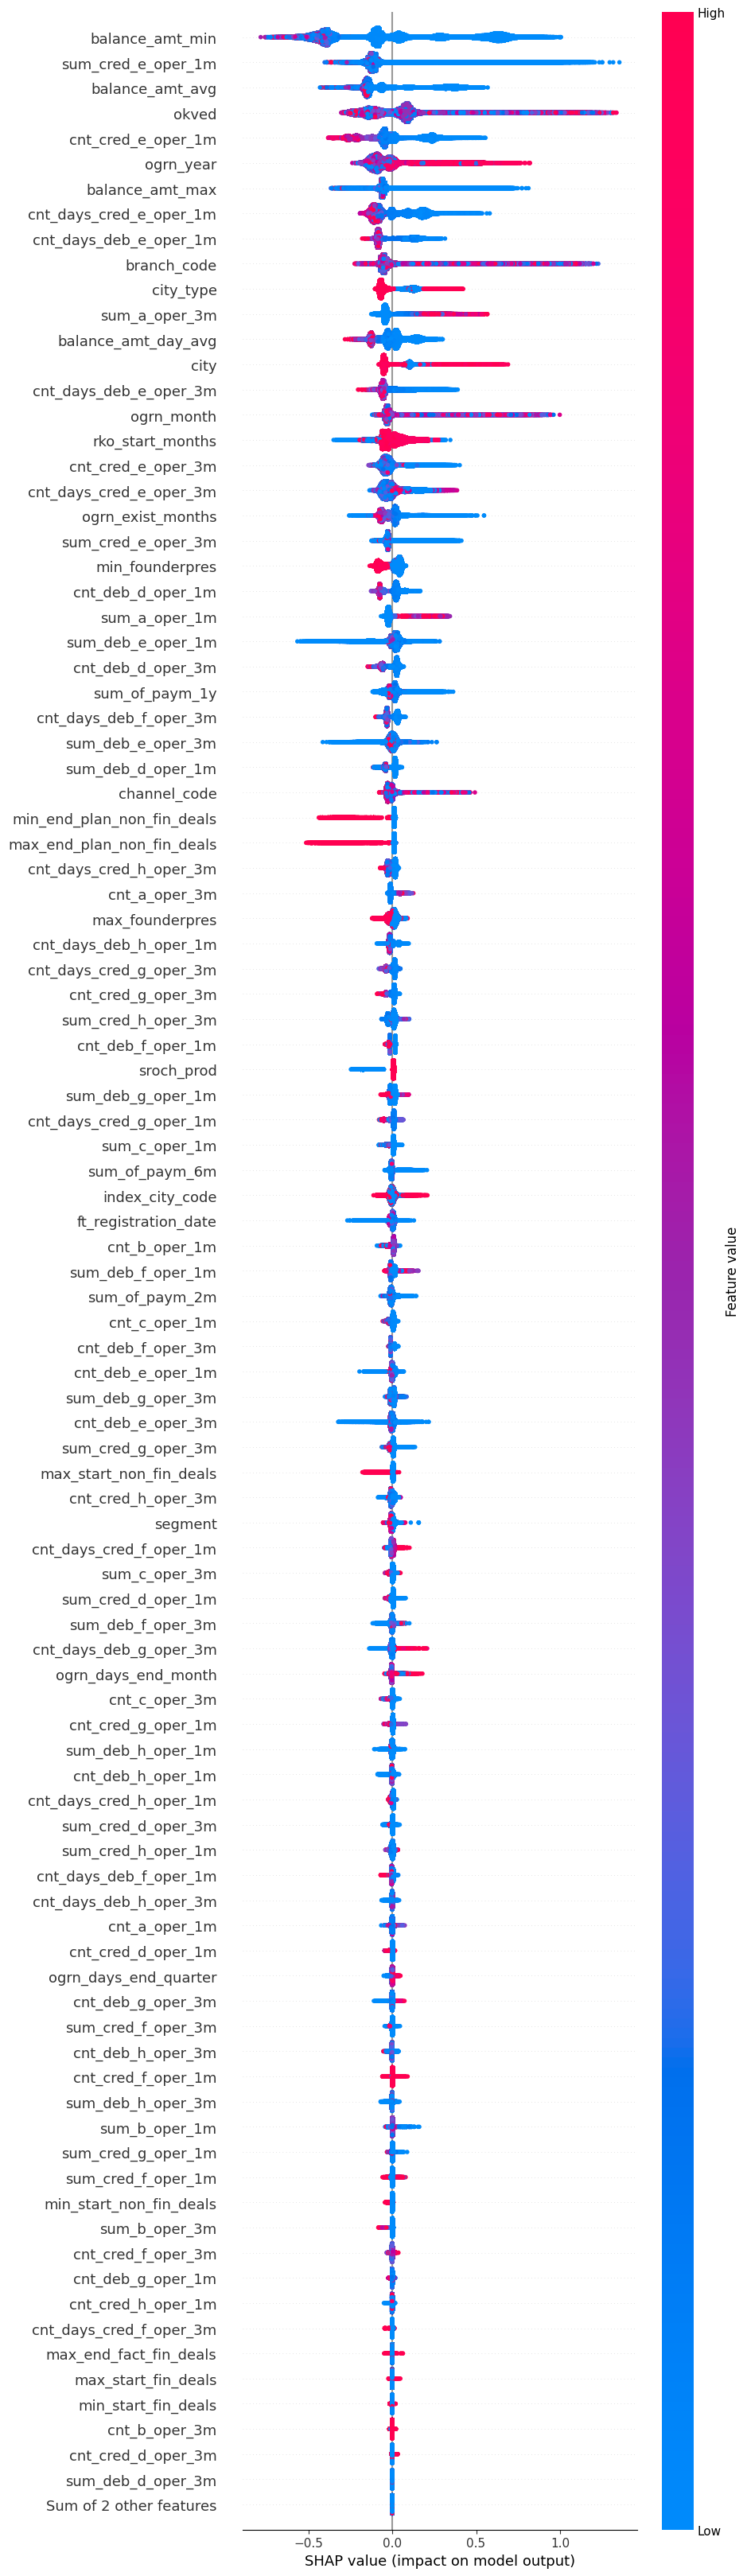

In [24]:
shap.plots.beeswarm(shap_values, max_display=99)

In [39]:
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')

In [56]:
group = train_df[['ogrn_month','total_target']].groupby('ogrn_month').agg(['mean','count']).reset_index()
group.columns = ['_'.join(col) for col in group.columns.values]
group.sort_values(by=['total_target_count','total_target_mean'], ascending=False)

,ogrn_month_,total_target_mean,total_target_count
3,11,0.065718,32548
0,0,0.060054,32504
1,1,0.061406,32407
6,4,0.082740,31726
10,8,0.071757,31328
4,2,0.085524,31196
8,6,0.078306,29602
9,7,0.080926,29533
2,10,0.059111,29267
7,5,0.068560,29011


<Axes: xlabel='ogrn_month_', ylabel='total_target_mean'>

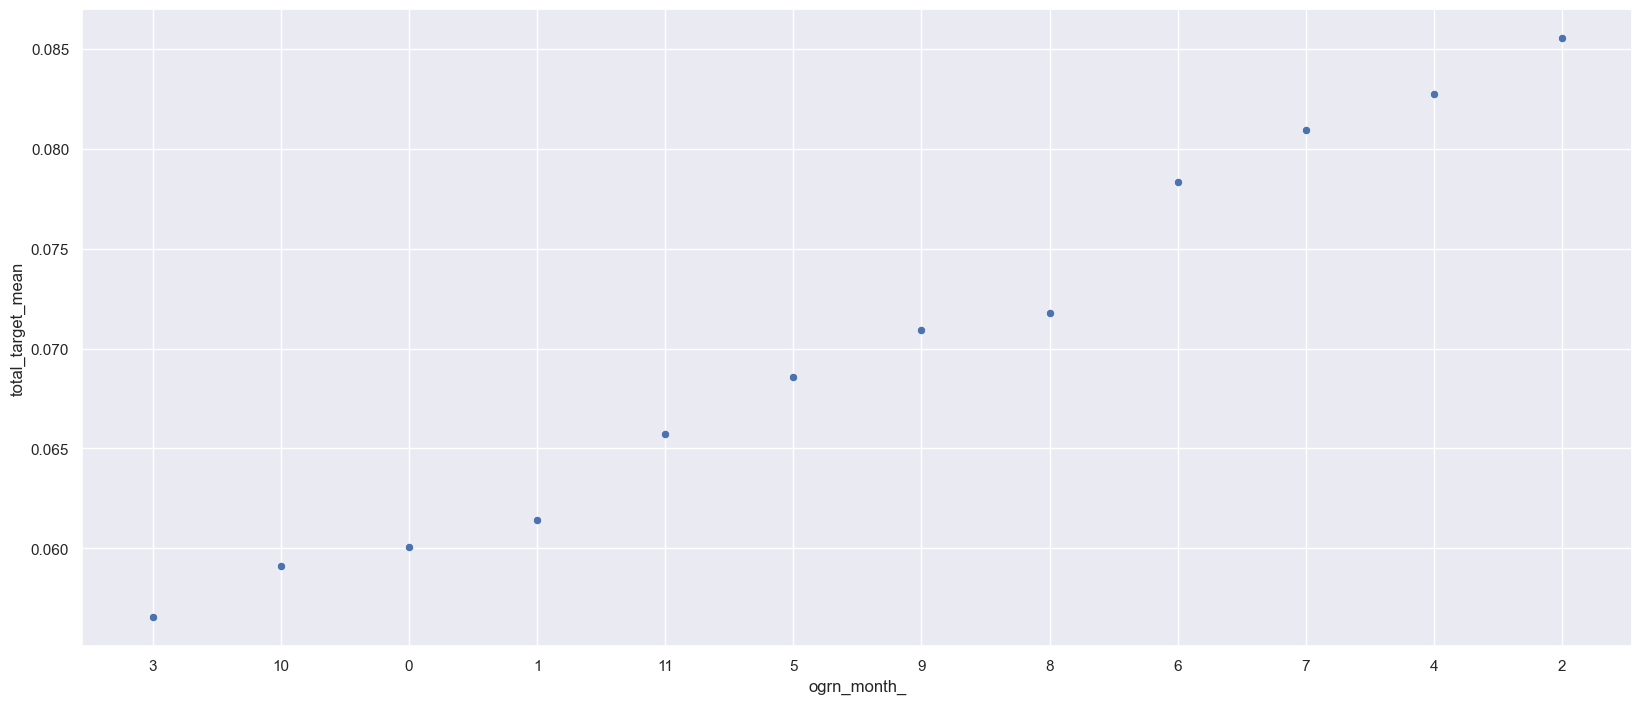

In [57]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.scatterplot(x=group[group['total_target_count']>1500].sort_values('total_target_mean')['ogrn_month_'], 
                y=group[group['total_target_count']>1500].sort_values('total_target_mean')['total_target_mean'])

In [74]:
group = train_df[['balance_amt_min','total_target']].groupby('balance_amt_min').agg(['mean','count']).reset_index()
group.columns = ['_'.join(col) for col in group.columns.values]
group.sort_values(by=['total_target_count','total_target_mean'], ascending=False)

,balance_amt_min_,total_target_mean,total_target_count
298135,3.725784e+09,0.058528,598
0,-2.289066e+03,0.083333,588
844,2.550731e+02,1.000000,3
1248,2.551388e+02,1.000000,3
1308,2.551461e+02,1.000000,3
...,...,...,...
298129,1.331740e+08,0.000000,1
298130,1.916590e+08,0.000000,1
298131,2.004400e+08,0.000000,1
298132,3.219650e+08,0.000000,1


<Axes: xlabel='balance_amt_min_', ylabel='total_target_mean'>

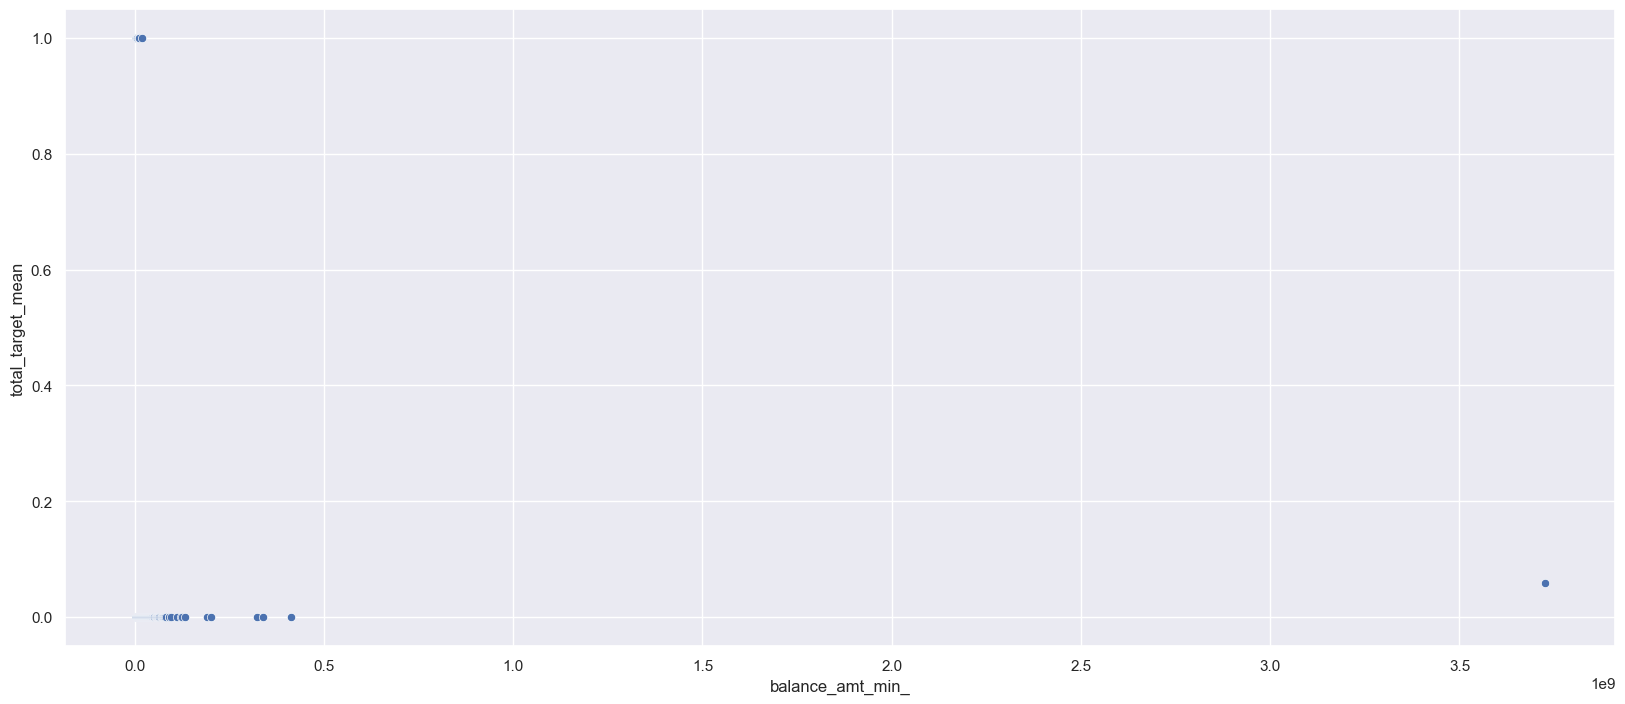

In [75]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.scatterplot(x=group[group['balance_amt_min_']>3000000].sort_values('total_target_mean')['balance_amt_min_'], 
                y=group[group['balance_amt_min_']>1].sort_values('total_target_mean')['total_target_mean'])

# Модель с двумя отдельными моделями под каждый target

## target 1

In [ ]:
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')
train_df['sroch_prod']=train_df[['max_end_plan_non_fin_deals', 'max_start_non_fin_deals', 'min_end_plan_non_fin_deals']].isna().any(axis=1).astype(int)
test_df['sroch_prod']=test_df[['max_end_plan_non_fin_deals', 'max_start_non_fin_deals', 'min_end_plan_non_fin_deals']].isna().any(axis=1).astype(int)
train_df.drop(["id", "total_target", "target_2"], axis=1, inplace=True)
train_df.fillna(-999999,inplace=True)
test_df.fillna(-999999,inplace=True)

cat_cols1 = [
    'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment',
    'max_end_fact_fin_deals', 'max_end_plan_non_fin_deals', 
    'max_start_fin_deals', 'max_start_non_fin_deals', 'min_end_fact_fin_deals', 'min_end_plan_non_fin_deals', 'min_start_fin_deals', 
         'min_start_non_fin_deals', 'ogrn_exist_months',
         'cnt_a_oper_1m', 'cnt_b_oper_1m', 'cnt_c_oper_1m', 'cnt_deb_d_oper_1m',
       'cnt_cred_d_oper_1m', 'cnt_deb_e_oper_1m', 'cnt_days_deb_e_oper_1m',
       'cnt_cred_e_oper_1m', 'cnt_days_cred_e_oper_1m', 'cnt_deb_f_oper_1m',
       'cnt_days_deb_f_oper_1m', 'cnt_days_cred_f_oper_1m',
       'cnt_deb_g_oper_1m', 'cnt_days_deb_g_oper_1m',
       'cnt_cred_g_oper_1m', 'cnt_days_cred_g_oper_1m', 'cnt_deb_h_oper_1m',
       'cnt_days_deb_h_oper_1m', 'cnt_cred_h_oper_1m',
       'cnt_days_cred_h_oper_1m', 'cnt_a_oper_3m', 'cnt_b_oper_3m',
       'cnt_c_oper_3m', 'cnt_deb_d_oper_3m', 'cnt_cred_d_oper_3m',
       'cnt_deb_e_oper_3m', 'cnt_days_deb_e_oper_3m', 'cnt_cred_e_oper_3m',
       'cnt_days_cred_e_oper_3m', 'cnt_deb_f_oper_3m',
       'cnt_days_deb_f_oper_3m', 'cnt_cred_f_oper_3m',
       'cnt_days_cred_f_oper_3m', 'cnt_deb_g_oper_3m',
       'cnt_days_deb_g_oper_3m', 'cnt_cred_g_oper_3m',
       'cnt_days_cred_g_oper_3m', 'cnt_deb_h_oper_3m',
       'cnt_days_deb_h_oper_3m', 'cnt_cred_h_oper_3m',
       'cnt_days_cred_h_oper_3m', 'sroch_prod'
]
train_df[cat_cols1] = train_df[cat_cols1].astype(int)
test_df[cat_cols1] = test_df[cat_cols1].astype(int,errors = 'ignore')
train_df[cat_cols1] = train_df[cat_cols1].astype("category")
test_df[cat_cols1] = test_df[cat_cols1].astype("category")
X = train_df.drop("target_1", axis=1)
y = train_df.target_1
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=4)

In [ ]:
eval_pool = Pool(X_val,y_val, cat_features=cat_cols1)
model1 = CatBoostClassifier(depth=9,cat_features=cat_cols1, task_type='GPU', boosting_type='Ordered', iterations=1800,min_data_in_leaf=50,learning_rate=0.1)
model1.fit(X_train,y_train, eval_set=eval_pool, early_stopping_rounds=50)

# target 2

In [ ]:
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')
train_df['sroch_prod']=train_df[['max_end_plan_non_fin_deals', 'max_start_non_fin_deals', 'min_end_plan_non_fin_deals']].isna().any(axis=1).astype(int)
test_df['sroch_prod']=test_df[['max_end_plan_non_fin_deals', 'max_start_non_fin_deals', 'min_end_plan_non_fin_deals']].isna().any(axis=1).astype(int)
train_df.drop(["id", "total_target", "target_1"], axis=1, inplace=True)
train_df.fillna(-999999,inplace=True)
test_df.fillna(-999999,inplace=True)

cat_cols2 = [
    'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment',
    'max_end_fact_fin_deals', 'max_end_plan_non_fin_deals', 
    'max_start_fin_deals', 'max_start_non_fin_deals', 'min_end_fact_fin_deals', 'min_end_plan_non_fin_deals', 'min_start_fin_deals', 
         'min_start_non_fin_deals', 'ogrn_exist_months',
         'cnt_a_oper_1m', 'cnt_b_oper_1m', 'cnt_c_oper_1m', 'cnt_deb_d_oper_1m',
       'cnt_cred_d_oper_1m', 'cnt_deb_e_oper_1m', 'cnt_days_deb_e_oper_1m',
       'cnt_cred_e_oper_1m', 'cnt_days_cred_e_oper_1m', 'cnt_deb_f_oper_1m',
       'cnt_days_deb_f_oper_1m', 'cnt_days_cred_f_oper_1m',
       'cnt_deb_g_oper_1m', 'cnt_days_deb_g_oper_1m',
       'cnt_cred_g_oper_1m', 'cnt_days_cred_g_oper_1m', 'cnt_deb_h_oper_1m',
       'cnt_days_deb_h_oper_1m', 'cnt_cred_h_oper_1m',
       'cnt_days_cred_h_oper_1m', 'cnt_a_oper_3m', 'cnt_b_oper_3m',
       'cnt_c_oper_3m', 'cnt_deb_d_oper_3m', 'cnt_cred_d_oper_3m',
       'cnt_deb_e_oper_3m', 'cnt_days_deb_e_oper_3m', 'cnt_cred_e_oper_3m',
       'cnt_days_cred_e_oper_3m', 'cnt_deb_f_oper_3m',
       'cnt_days_deb_f_oper_3m', 'cnt_cred_f_oper_3m',
       'cnt_days_cred_f_oper_3m', 'cnt_deb_g_oper_3m',
       'cnt_days_deb_g_oper_3m', 'cnt_cred_g_oper_3m',
       'cnt_days_cred_g_oper_3m', 'cnt_deb_h_oper_3m',
       'cnt_days_deb_h_oper_3m', 'cnt_cred_h_oper_3m',
       'cnt_days_cred_h_oper_3m', 'sroch_prod'
]
train_df[cat_cols2] = train_df[cat_cols2].astype(int)
test_df[cat_cols2] = test_df[cat_cols2].astype(int,errors = 'ignore')
train_df[cat_cols2] = train_df[cat_cols2].astype("category")
test_df[cat_cols2] = test_df[cat_cols2].astype("category")
X = train_df.drop("target_2", axis=1)
y = train_df.target_2
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=3)

In [ ]:
eval_pool = Pool(X_val,y_val, cat_features=cat_cols2)
model2 = CatBoostClassifier(depth=12,cat_features=cat_cols2, task_type='GPU', boosting_type='Ordered', iterations=1700,min_data_in_leaf=40,learning_rate=0.05)
model2.fit(X_train,y_train, eval_set=eval_pool, early_stopping_rounds=50)

In [ ]:
pd.DataFrame({'id':test_df['id'],'score':np.array((model1.predict_proba(test_df.drop(columns='id'))[:,1], model2.predict_proba(test_df.drop(columns='id'))[:,1])).max(axis=0)}).to_csv('fin_sub5.csv',index=False)

# Optuna params tuning

In [ ]:
def objective(trial):
    param = {
        'iterations':trial.suggest_int("iterations", 400, 2000),
        'learning_rate' : trial.suggest_categorical ('learning_rate',[0.001,0.005,0.01,0.1,1,10]),
        "objective": "CrossEntropy",
        'od_wait':trial.suggest_int('od_wait', 10, 100),
        "depth": trial.suggest_int("depth", 1, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',3,30),
        'random_strength': trial.suggest_float('random_strength',1,55),
        "boosting_type": "Ordered",
        "task_type":"GPU",
        "bootstrap_type": "Bayesian",
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 10)
    }

    cv = StratifiedKFold(shuffle=True, random_state=500, n_splits=4)
    X = train_df.drop("total_target", axis=1)
    y = train_df.total_target
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)
    
    model = CatBoostClassifier(**param,verbose=False,cat_features=cat_cols)
    cross_valid = cross_validate(model, X_train, y_train, scoring='roc_auc', cv=cv, return_estimator=True)
    print(cross_valid['test_score'])
    return min(cross_valid['test_score'])

In [ ]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=200)